# Mitochondria and synapses - Figure S3

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from scipy.stats import pearsonr, ranksums, ttest_ind

%matplotlib inline

In [2]:
timepoint = [5, 23, 27, 50, 69.5]
bound = [15, 25, 35, 47, 62]
stage_cmap = sns.color_palette("deep",8)
type_cmap = [(253/255, 225/255, 245/255),
             (1, 183/255, 139/255),
             (167/255, 217/255, 245/255)]

## Load data

In [3]:
cell_df = pd.read_csv("neuron_list_hobert.csv")
cell_df.head()

,name,id,type,class,neurotransmitter1,neurotransmitter2,l1_vol,l2_vol,l3_vol,adult_vol,dauer_vol
0,ADAL,1,2,ADA,Glutamate,NaN,0.701728,1.273221,1.371940,3.494185,1.159168
1,ADAR,2,2,ADA,Glutamate,NaN,0.644497,1.260319,1.613807,2.878003,1.017088
2,ADEL,3,1,ADE,Dopamine,NaN,0.364170,1.336320,1.832287,7.324293,0.791347
3,ADER,4,1,ADE,Dopamine,NaN,0.297124,1.328579,1.841921,6.864507,0.781312
4,ADFL,5,1,ADF,Acetylcholine,Serotonin,0.753066,1.446728,2.018413,3.728548,1.827789


In [4]:
l1_mito_df = pd.read_csv("240527_dataset2_mito_neuron.csv")
l2_mito_df = pd.read_csv("240527_dataset5_mito_neuron.csv")
l3_mito_df = pd.read_csv("240527_dataset6_mito_neuron.csv")
adult_mito_df = pd.read_csv("240527_dataset8_mito_neuron.csv")
dauer_mito_df = pd.read_csv("240527_dauer1_mito_neuron.csv")
dauer_mito_df.head()

,cell_name,cell_id,cell_common_id,class,mito_id,cell_vol,mito_vol,cell_surf,mito_surf,x_pos,y_pos,z_pos,mito_len,dist_pre,dist_post
0,AIBR,15,14,2,747,2.679757,0.021658,29.616532,0.372357,5.868936,2.328813,4.282388,1.328166,0.619359,0.666193
1,AIBR,15,14,2,977,2.679757,0.022989,29.616532,0.438184,7.818976,3.981256,5.437973,0.960554,0.472862,0.581278
2,AIBR,15,14,2,1346,2.679757,0.008806,29.616532,0.194831,4.602977,2.567442,7.082849,0.874920,2.611763,0.339316
3,AIBR,15,14,2,1400,2.679757,0.020378,29.616532,0.411419,7.925869,5.646151,7.352387,1.726368,0.232002,0.817458
4,AIBR,15,14,2,2008,2.679757,0.010291,29.616532,0.250027,6.260060,7.735721,10.437065,1.414361,0.206209,0.813789


In [5]:
l1_syn_df = pd.read_csv("240527_dataset2_synapse.csv")
l2_syn_df = pd.read_csv("240527_dataset5_synapse.csv")
l3_syn_df = pd.read_csv("240527_dataset6_synapse.csv")
adult_syn_df = pd.read_csv("240527_dataset8_synapse.csv")
dauer_syn_df = pd.read_csv("240527_dauer1_synapse.csv")
dauer_syn_df.head()

,syn_id,pre,pre_id,pre_common_id,post,post_id,post_common_id,x_pos,y_pos,z_pos,size
0,1,RIH,145,124,CEPDL,187,71,6264,3540,50,56629.85685
1,1,RIH,145,124,OLQDL,189,95,6264,3540,50,115370.14310
2,2,RIH,145,124,URXR,179,181,3312,3848,50,529157.36040
3,2,RIH,145,124,IL2DR,182,88,3312,3848,50,153855.83760
4,2,RIH,145,124,CEPDR,186,72,3312,3848,50,17786.80203


In [8]:
def get_syn_size(syn_df):
    
    syn_id_list = np.unique(syn_df["syn_id"])
    n = syn_id_list.shape[0]
    syn_size = np.zeros(n)
    for i in range(n):

        syn_id = syn_id_list[i]
        syn_loc = syn_df[syn_df["syn_id"]==syn_id][["x_pos", "y_pos", "z_pos"]].values[0,:]/1000
        cell_id = syn_df[syn_df["syn_id"]==syn_id]["pre_common_id"].values[0]

        syn_size[i] = np.sum(syn_df[syn_df["syn_id"]==syn_id]["size"])/10**9
        
    return syn_size

def dist(x, y):
    
    x = x.reshape((-1,3))
    y = y.reshape((-1,3))
    
    return np.sum((x-y)**2, axis=1)**0.5

def get_dist_from_syn(syn_df, mito_df, mode="pre"):
    
    if mode=="pre":
        
        syn_id_list = np.unique(syn_df["syn_id"])
        n = syn_id_list.shape[0]
        dist_from_syn = np.zeros(n)
        for i in range(n):
            
            syn_id = syn_id_list[i]
            syn_loc = syn_df[syn_df["syn_id"]==syn_id][["x_pos", "y_pos", "z_pos"]].values[0,:]/1000
            cell_id = syn_df[syn_df["syn_id"]==syn_id]["pre_common_id"].values[0]

            valid = mito_df["cell_common_id"]==cell_id
            if np.sum(valid)==0:
                continue
            mito_loc_list = mito_df[valid][["x_pos", "y_pos", "z_pos"]].values
            dist_list = dist(mito_loc_list, syn_loc)
            dist_from_syn[i] = np.min(dist_list)
            
    elif mode=="post":
        
        n = syn_df.shape[0]
        dist_from_syn = np.zeros(n)
        for i in range(n):
        
            syn_loc = syn_df.iloc[i][["x_pos", "y_pos", "z_pos"]].values/1000
            cell_id = syn_df.iloc[i]["post_common_id"]

            valid = mito_df["cell_common_id"]==cell_id
            if np.sum(valid)==0:
                continue
            mito_loc_list = mito_df[valid][["x_pos", "y_pos", "z_pos"]].values
            dist_list = dist(mito_loc_list, syn_loc)
            dist_from_syn[i] = np.min(dist_list)
    
    return dist_from_syn

def get_dist_from_mito(mito_df, syn_df, mode="pre"):
    
    syn_loc_list = syn_df[["x_pos", "y_pos", "z_pos"]].values/1000
    
    nmito = mito_df.shape[0]
    
    dist_from_mito = np.zeros(nmito)
    for i in range(nmito):
        
        cell_id = mito_df.iloc[i]["cell_common_id"]
        mito_loc = mito_df.iloc[i][["x_pos", "y_pos", "z_pos"]].values
                                 
        if mode=="pre":
            
            valid = syn_df["pre_common_id"]==cell_id
            if np.sum(valid):
                
                dist_list = dist(syn_loc_list[valid,:], mito_loc)
                dist_from_mito[i] = np.min(dist_list)
                
        elif mode=="post":
            
            valid = syn_df["post_common_id"]==cell_id
            if np.sum(valid):
                
                dist_list = dist(syn_loc_list[valid,:], mito_loc)
                dist_from_mito[i] = np.min(dist_list)
                
    return dist_from_mito

In [9]:
l1_dmito_pre = get_dist_from_syn(l1_syn_df, l1_mito_df, "pre")
l2_dmito_pre = get_dist_from_syn(l2_syn_df, l2_mito_df, "pre")
l3_dmito_pre = get_dist_from_syn(l3_syn_df, l3_mito_df, "pre")
adult_dmito_pre = get_dist_from_syn(adult_syn_df, adult_mito_df, "pre")
dauer_dmito_pre = get_dist_from_syn(dauer_syn_df, dauer_mito_df, "pre")

l1_syn_size = get_syn_size(l1_syn_df)
l2_syn_size = get_syn_size(l2_syn_df)
l3_syn_size = get_syn_size(l3_syn_df)
adult_syn_size = get_syn_size(adult_syn_df)
dauer_syn_size = get_syn_size(dauer_syn_df)

valid = l1_dmito_pre>0
l1_dmito_pre = l1_dmito_pre[valid]
l1_syn_size = l1_syn_size[valid]

valid = l2_dmito_pre>0
l2_dmito_pre = l2_dmito_pre[valid]
l2_syn_size = l2_syn_size[valid]

valid = l3_dmito_pre>0
l3_dmito_pre = l3_dmito_pre[valid]
l3_syn_size = l3_syn_size[valid]

valid = adult_dmito_pre>0
adult_dmito_pre = adult_dmito_pre[valid]
adult_syn_size = adult_syn_size[valid]

valid = dauer_dmito_pre>0
dauer_dmito_pre = dauer_dmito_pre[valid]
dauer_syn_size = dauer_syn_size[valid]

In [11]:
l1_dsyn_pre = get_dist_from_mito(l1_mito_df, l1_syn_df, "pre")
l1_dsyn_post = get_dist_from_mito(l1_mito_df, l1_syn_df, "post")
l1_mitovol = l1_mito_df["mito_vol"].values

l2_dsyn_pre = get_dist_from_mito(l2_mito_df, l2_syn_df, "pre")
l2_dsyn_post = get_dist_from_mito(l2_mito_df, l2_syn_df, "post")
l2_mitovol = l2_mito_df["mito_vol"].values

l3_dsyn_pre = get_dist_from_mito(l3_mito_df, l3_syn_df, "pre")
l3_dsyn_post = get_dist_from_mito(l3_mito_df, l3_syn_df, "post")
l3_mitovol = l3_mito_df["mito_vol"].values

adult_dsyn_pre = get_dist_from_mito(adult_mito_df, adult_syn_df, "pre")
adult_dsyn_post = get_dist_from_mito(adult_mito_df, adult_syn_df, "post")
adult_mitovol = adult_mito_df["mito_vol"].values

dauer_dsyn_pre = get_dist_from_mito(dauer_mito_df, dauer_syn_df, "pre")
dauer_dsyn_post = get_dist_from_mito(dauer_mito_df, dauer_syn_df, "post")
dauer_mitovol = dauer_mito_df["mito_vol"].values

In [12]:
valid = l1_dsyn_pre>0
l1_mitovol_pre = l1_mitovol[valid]
l1_dsyn_pre = l1_dsyn_pre[valid]

valid = l2_dsyn_pre>0
l2_mitovol_pre = l2_mitovol[valid]
l2_dsyn_pre = l2_dsyn_pre[valid]

valid = l3_dsyn_pre>0
l3_mitovol_pre = l3_mitovol[valid]
l3_dsyn_pre = l3_dsyn_pre[valid]

valid = adult_dsyn_pre>0
adult_mitovol_pre = adult_mitovol[valid]
adult_dsyn_pre = adult_dsyn_pre[valid]

valid = dauer_dsyn_pre>0
dauer_mitovol_pre = dauer_mitovol[valid]
dauer_dsyn_pre = dauer_dsyn_pre[valid]


valid = l1_dsyn_post>0
l1_mitovol_post = l1_mitovol[valid]
l1_dsyn_post = l1_dsyn_post[valid]

valid = l2_dsyn_post>0
l2_mitovol_post = l2_mitovol[valid]
l2_dsyn_post = l2_dsyn_post[valid]

valid = l3_dsyn_post>0
l3_mitovol_post = l3_mitovol[valid]
l3_dsyn_post = l3_dsyn_post[valid]

valid = adult_dsyn_post>0
adult_mitovol_post = adult_mitovol[valid]
adult_dsyn_post = adult_dsyn_post[valid]

valid = dauer_dsyn_post>0
dauer_mitovol_post = dauer_mitovol[valid]
dauer_dsyn_post = dauer_dsyn_post[valid]

In [108]:
fs_tick = 12
fs_lab = 14

def plot1(ax, x, y, knee, yticks, yticklab, ylim, stage):
    
    xticks = [0,1,2,3,4,5,6]
    xticklab = ["0","","2","","4","","6"]
    
    ax.vlines(knee, ylim[0], ylim[1], color="r", linestyles="dashed",
              linewidth=1)
    ax.plot(x, y, "k.",
            alpha=0.6, markeredgewidth=0, markersize=6)
    ax.text(0.95*6, 0.95*(ylim[1]-ylim[0]), stage, fontsize=fs_lab, fontname="Arial",
            verticalalignment="top", horizontalalignment="right")
    
    ax.set_xlim(0,6)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
#     ax.set_xlabel("$d_{mito}^{pre}$", fontsize=fs_lab, fontname="Arial")
    ax.set_ylabel("Syn. size ($\mu$m$^3$)", fontsize=fs_lab, fontname="Arial")
    
def plot2(ax, x, y, knee, yticks, yticklab, ylim):
    
    xticks = [0,1,2,3,4,5,6]
    xticklab = ["0","","2","","4","","6"]
    
    ax.vlines(knee, ylim[0], ylim[1], color="r", linestyles="dashed",
              linewidth=1)
    ax.plot(x, y, "k.",
            alpha=0.6, markeredgewidth=0, markersize=6)
    
    ax.set_xlim(0,6)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
#     ax.set_xlabel("$d_{syn}^{pre}$", fontsize=fs_lab, fontname="Arial")
    ax.set_ylabel("Mito. volume ($\mu$m$^3$)", fontsize=fs_lab, fontname="Arial")
    
def plot3(ax, x, y, knee, yticks, yticklab, ylim):
    
    xticks = [0,1,2,3,4,5,6]
    xticklab = ["0","","2","","4","","6"]
    
    ax.vlines(knee, ylim[0], ylim[1], color="r", linestyles="dashed",
              linewidth=1)
    ax.plot(x, y, "k.",
            alpha=0.6, markeredgewidth=0, markersize=6)
    
    ax.set_xlim(0,6)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
#     ax.set_xlabel("$d_{syn}^{post}$", fontsize=fs_lab, fontname="Arial")
    ax.set_ylabel("Mito. volume ($\mu$m$^3$)", fontsize=fs_lab, fontname="Arial")

In [109]:
stage_list = ["L1","L2","L3","Adult","Dauer"]
knee_list = [1.3, 1.3, 1.1, 1.1, 1.1]

dmito_pre_list = [l1_dmito_pre, l2_dmito_pre, l3_dmito_pre, adult_dmito_pre, dauer_dmito_pre]
syn_size_list = [l1_syn_size, l2_syn_size, l3_syn_size, adult_syn_size, dauer_syn_size]

ylim1_list = [(0,0.0039), (0,0.0039), (0,0.0095), (0,0.0081), (0,0.0101)]
ytw1_list = [0.001, 0.001, 0.002, 0.002, 0.002]
yticks1_list = [np.arange(ylim1_list[i][0],ylim1_list[i][1],ytw1_list[i]) for i in range(5)]
yticklab1_list = [["0","0.001","0.002","0.003"],
                  ["0","0.001","0.002","0.003"],
                  ["0","0.002","0.004","0.006","0.008"],
                  ["0","0.002","0.004","0.006","0.008"],
                  ["0","0.002","0.004","0.006","0.008","0.010"]]


dsyn_pre_list = [l1_dsyn_pre, l2_dsyn_pre, l3_dsyn_pre, adult_dsyn_pre, dauer_dsyn_pre]
mitovol_pre_list = [l1_mitovol_pre, l2_mitovol_pre, l3_mitovol_pre, adult_mitovol_pre, dauer_mitovol_pre]

dsyn_post_list = [l1_dsyn_post, l2_dsyn_post, l3_dsyn_post, adult_dsyn_post, dauer_dsyn_post]
mitovol_post_list = [l1_mitovol_post, l2_mitovol_post, l3_mitovol_post, adult_mitovol_post, dauer_mitovol_post]

ylim2_list = [(0,0.052), (0,0.102), (0,0.195), (0,0.19), (0,0.095)]
ytw2_list = [0.02, 0.05, 0.05, 0.05, 0.02]
yticks2_list = [np.arange(ylim2_list[i][0],ylim2_list[i][1],ytw2_list[i]) for i in range(5)]
yticklab2_list = [["0","0.02","0.04"],
                  ["0","0.05","0.10"],
                  ["0","0.05","0.10","0.15"],
                  ["0","0.05","0.10","0.15"],
                  ["0","0.02","0.04","0.06","0.08"]]

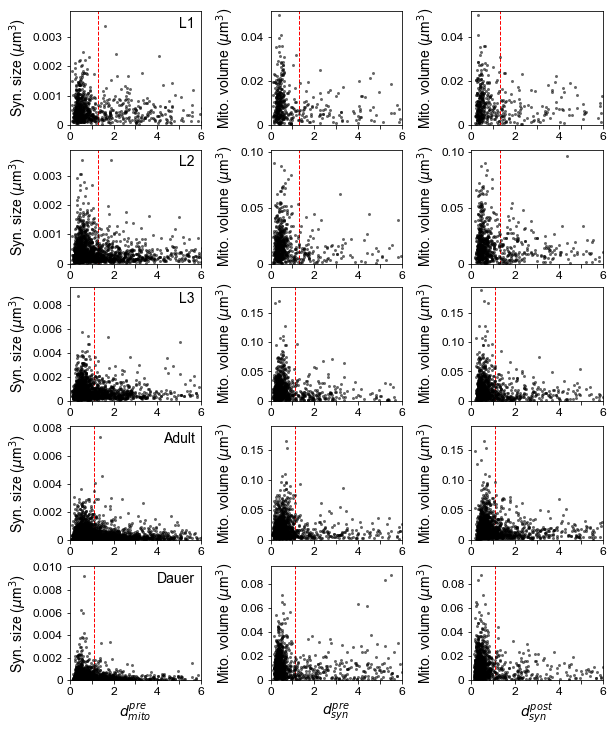

In [110]:
fig = plt.figure(figsize=(8.4,10), constrained_layout=True)
gs = fig.add_gridspec(5,3,wspace=0.05,hspace=0.01)

for i in range(5):
    ax = fig.add_subplot(gs[i,0])
    plot1(ax, dmito_pre_list[i], syn_size_list[i], knee_list[i],
          yticks1_list[i], yticklab1_list[i], ylim1_list[i], stage_list[i])
    if i==4:
        ax.set_xlabel("$d_{mito}^{pre}$", fontsize=fs_lab, fontname="Arial")
    
for i in range(5):
    ax = fig.add_subplot(gs[i,1])
    plot2(ax, dsyn_pre_list[i], mitovol_pre_list[i], knee_list[i],
          yticks2_list[i], yticklab2_list[i], ylim2_list[i])
    if i==4:
        ax.set_xlabel("$d_{syn}^{pre}$", fontsize=fs_lab, fontname="Arial")
        
for i in range(5):
    ax = fig.add_subplot(gs[i,2])
    plot3(ax, dsyn_post_list[i], mitovol_post_list[i], knee_list[i],
          yticks2_list[i], yticklab2_list[i], ylim2_list[i])
    if i==4:
        ax.set_xlabel("$d_{syn}^{post}$", fontsize=fs_lab, fontname="Arial")

plt.savefig("/home/jabae/Dropbox/SNU/Research/Celegans/Cmito/figures/figure_v2/panels/figS3.svg")
plt.show()